In [1]:
import numpy as np
import chainer
from chainer import training
from chainer.training import extensions
# matplotlibを使ったグラフ描画結果がnotebook内に表示されるようにします。
%matplotlib inline
import matplotlib.pyplot as plt

/home/kumezawa/dev/cupy/cupy/core/fusion.py:659: FutureWarning: cupy.core.fusion is experimental. The interface can change in the future.
  util.experimental('cupy.core.fusion')


# データセットの準備
ここでは、Chainerが用意しているMNISTデータセットを使うための便利なメソッドを利用します。これを使うと、データのダウンロードから、一つ一つのデータを取り出せるようにするところまでが隠蔽されます。

In [2]:
# Load the MNIST dataset
train, test = chainer.datasets.get_mnist(withlabel=True, ndim=1)

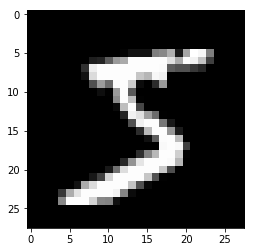

label: 5


In [3]:
# データの例示
x, t = train[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

# Iteratorの作成
データセットから決まった数のデータを取り出し、それらを束ねてミニバッチを作成して返してくれるIteratorを作成しましょう。これをこの後の学習ループの中で使用していきます。イテレータは、next()メソッドで新しいミニバッチを返してくれます。内部ではデータセットを何周なめたか（epoch）、現在のイテレーションが新しいepochの最初のイテレーションか、などを管理するプロパティ（is_new_epoch）などを持っています。

In [4]:
# iteratorsの設定
batchsize = 20

train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

# モデルの定義

In [5]:
import chainer.links as L
import chainer.functions as F

In [6]:
# MLP: Multi-layer Perceptron
class MLP(chainer.Chain):
    
    def __init__(self, n_units1, n_units2, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units1)
            self.l2 = L.Linear(None, n_units2)
            self.l3 = L.Linear(None, n_output)
            
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [7]:
# モデルの宣言
np.random.seed(1) # 乱数のシードを固定

gpu_id = 0  # change to 0 if using GPU

n_units1, n_units2, n_output = 100, 100, 10
model     = MLP(n_units1, n_units2, n_output)

if gpu_id >= 0:
    model.to_gpu(gpu_id)

model = L.Classifier(model)

if gpu_id >= 0:
    model.to_gpu(gpu_id)

# 最適化手法の選択
Chainerは多くの最適化手法を提供しています。chainer.optimizersモジュール以下にそれらはあります。ここでは最もシンプルな勾配降下法の手法であるoptimizers.SGDを用います。Optimizerのオブジェクトには、setupメソッドを使ってモデル（Chainオブジェクト）を渡します。こうすることでOptimizerは、自身が更新すべきモデル内のパラメータを自動的にたどってくれます。

他にもいろいろな最適化手法が手軽に試せるので、色々と試してみて結果の変化を見てみてください。例えば、下のchainer.optimizers.SGDのうちSGDの部分をMomentumSGD, RMSprop,  Adamなどに変えて、結果の違いを見てみましょう。

In [8]:
optimizer = chainer.optimizers.SGD()
optimizer.setup(model)

# Trainerの設定

In [9]:
# updaterの設定
from chainer import training
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)
# trainerとそのextensionsの設定
from chainer.training import extensions

# trainerの基本設定
## epoch = 1000
epoch = 10
trainer = training.Trainer(updater, (epoch, 'epoch'), out='mnist_result')

# 評価データで評価
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))

# 学習結果の途中を表示する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))

# １エポックごとに、trainデータに対するaccuracyと、testデータに対するaccuracyを出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']), trigger=(1, 'epoch'))

# 定期的にモデルやOptimizerの状態を自動シリアライズ(保存)
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))

In [10]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  elapsed_time
1           0.840211       0.914701                  14.473        
2           0.922657       0.932601                  28.416        
3           0.937904       0.944201                  42.2929       
4           0.947605       0.950501                  56.414        
5           0.954553       0.9549                    69.769        
6           0.960155       0.960401                  81.552        
7           0.964555       0.963201                  95.5275       
8           0.968673       0.9653                    108.728       
9           0.970706       0.9665                    121.996       
10          0.973189       0.9681                    134.774       


# 結果の確認

In [11]:
import matplotlib.pyplot as plt

In [12]:
import json

with open('result/log') as f:
     logs = json.load(f)

In [13]:
# 損失関数のプロット

In [14]:
loss_train = [ log['main/loss'] for log in logs ]
loss_test  = [ log['validation/main/loss'] for log in logs ]

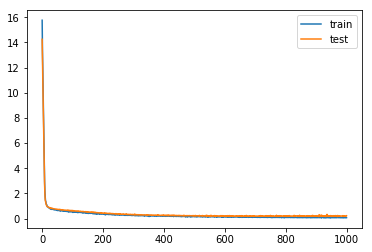

In [15]:
plt.plot(loss_train, label='train')  # 訓練データ
plt.plot(loss_test,  label='test')  # 検証データ
plt.legend()  # 凡例表示
plt.show()

In [16]:
accuracy_train = [ log['main/accuracy'] for log in logs ]
accuracy_test  = [ log['validation/main/accuracy'] for log in logs ]

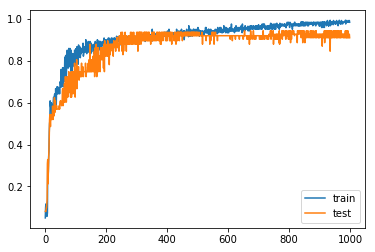

In [17]:
plt.plot(accuracy_train, label='train')  # 訓練データ
plt.plot(accuracy_test,  label='test')  # 検証データ
plt.legend()  # 凡例表示
plt.show()

# 学習済みモデルで推論

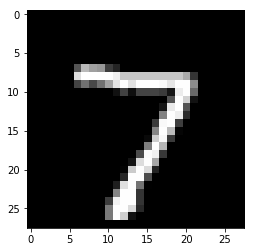

label: 7
predicted_label: 7


In [18]:
import numpy as np
from chainer import serializers
from chainer.cuda import to_gpu
from chainer.cuda import to_cpu

n_units1, n_units2, n_output = 100, 100, 10
model     = MLP(n_units1, n_units2, n_output)
serializers.load_npz('mnist_result/model_epoch-10', model)
    
%matplotlib inline
import matplotlib.pyplot as plt

x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

if gpu_id >= 0:
    model.to_gpu(gpu_id)
    x = to_gpu(x[None, ...])
    y = model(x)
    y = to_cpu(y.data)
else:    
    x = x[None, ...]
    y = model(x)
    y = y.data

print('predicted_label:', y.argmax(axis=1)[0])

# オーバーフィッティング対策
ドロップアウトを入れることで、オーバーフィッティングが防げるか試す

In [19]:
# MLP: Multi-layer Perceptron
class MLP(chainer.Chain):
    
    def __init__(self, n_units1, n_units2, n_output):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units1)
            self.l2 = L.Linear(None, n_units2)
            self.l3 = L.Linear(None, n_output)
            
    def __call__(self, x, train=True):
        if train:
            h1 = F.dropout( F.relu(self.l1(x)), ratio=0.2)
            h2 = F.dropout( F.relu(self.l2(h1)), ratio=0.2 )
            return self.l3(h2)
        else:
            h1 = F.relu(self.l1(x))
            h2 = F.relu(self.l2(h1))
            return self.l3(h2)

In [29]:
# iteratorsの設定
batchsize = 20

train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)

# モデルの宣言
np.random.seed(1) # 乱数のシードを固定

gpu_id = 0  # change to 0 if using GPU

n_units1, n_units2, n_output = 100, 100, 10
model     = MLP(n_units1, n_units2, n_output)

if gpu_id >= 0:
    model.to_gpu(gpu_id)

model = L.Classifier(model)

if gpu_id >= 0:
    model.to_gpu(gpu_id)

In [30]:
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [31]:
# updaterの設定
from chainer import training
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)
# trainerとそのextensionsの設定
from chainer.training import extensions

# trainerの基本設定
## epoch = 1000
epoch = 10
trainer = training.Trainer(updater, (epoch, 'epoch'), out='mnist_result')

# 評価データで評価
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))

# 学習結果の途中を表示する
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))

# １エポックごとに、trainデータに対するaccuracyと、testデータに対するaccuracyを出力させる
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']), trigger=(1, 'epoch'))

# 定期的にモデルやOptimizerの状態を自動シリアライズ(保存)
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))

In [32]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  elapsed_time
1           0.904656       0.9574                    16.3008       
2           0.951204       0.964501                  33.6129       
3           0.960138       0.9713                    49.9645       
4           0.964954       0.973901                  67.5104       
5           0.969055       0.9753                    86.5742       
6           0.970806       0.9761                    104.268       
7           0.973156       0.978801                  122.582       
8           0.975157       0.9761                    140.46        
9           0.976107       0.979                     158.542       
10          0.976107       0.980401                  176.309       


# 結果の確認

In [33]:
import json

with open('result/log') as f:
     logs = json.load(f)

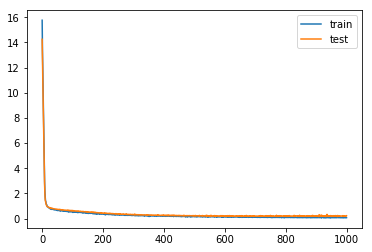

In [34]:
# 損失関数のプロット
loss_train = [ log['main/loss'] for log in logs ]
loss_test  = [ log['validation/main/loss'] for log in logs ]

plt.plot(loss_train, label='train')  # 訓練データ
plt.plot(loss_test,  label='test')  # 検証データ
plt.legend()  # 凡例表示
plt.show()

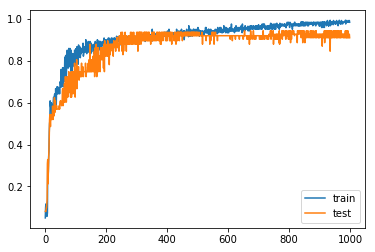

In [35]:
# 正解率のプロット
accuracy_train = [ log['main/accuracy'] for log in logs ]
accuracy_test  = [ log['validation/main/accuracy'] for log in logs ]

plt.plot(accuracy_train, label='train')  # 訓練データ
plt.plot(accuracy_test,  label='test')  # 検証データ
plt.legend()  # 凡例表示
plt.show()

# 学習済みモデルで推論

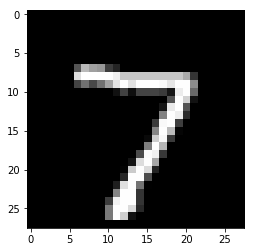

label: 7
predicted_label: 7


In [36]:
import numpy as np
from chainer import serializers
from chainer.cuda import to_gpu
from chainer.cuda import to_cpu

n_units1, n_units2, n_output = 100, 100, 10
model     = MLP(n_units1, n_units2, n_output)
serializers.load_npz('mnist_result/model_epoch-10', model)
    
%matplotlib inline
import matplotlib.pyplot as plt

x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

if gpu_id >= 0:
    model.to_gpu(gpu_id)
    x = to_gpu(x[None, ...])
    y = model(x)
    y = to_cpu(y.data)
else:    
    x = x[None, ...]
    y = model(x)
    y = y.data

print('predicted_label:', y.argmax(axis=1)[0])